In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from support.charting import primaryColors, fullColors, save_fig
from support.load     import loadAllData, methodParams
from support.util     import titles, order, robustOutcomeOrder

from IPython.core import display as ICD

/Users/eebart/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/eebart/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
data = loadAllData()
sns.set_style('white')

--------------------------------
Loading MOEA intertemporal
Loading archives from ../data/mordm/optimize/archives_intertemporal_NSGAIIHybrid_runs50_nfe500000_scenarios10000_refScenario-1.csv
Loading convergences from ../data/mordm/optimize/convergences_intertemporal_NSGAIIHybrid_runs50_nfe500000_scenarios10000_refScenario-1.csv
Loading Pareto for intertemporal
Loading pareto from ../data/mordm/optimize/nondominated_intertemporal_NSGAIIHybrid_runs50_nfe500000_scenarios10000_refScenario-1.csv
Loading Robustness Summary intertemporal
Loading Robust Summary from ../data/mordm/robustness/summary_intertemporal_NSGAIIHybrid_runs50_nfe500000_scenarios10000_refScenario-1.csv
--------------------------------
Loading MOEA plannedadaptive
Loading archives from ../data/mordm/optimize/archives_plannedadaptive_NSGAIIHybrid_runs50_nfe100000_scenarios10000_refScenario-1.csv
Loading convergences from ../data/mordm/optimize/convergences_plannedadaptive_NSGAIIHybrid_runs50_nfe100000_scenarios10000_refScen

In [3]:
#build dataframes to summarize robust data. This is used for most of the charts in this notebook. 
robustData = []
for method in data.keys(): 
    for model in order('model'):
        for idx, rbData in enumerate(data[method]['robusts'][model]):
            ref = idx
            if len(rbData) == 1 or idx == len(rbData) - 1: 
                ref = -1
            rb = rbData[order('outcome')]
            rb['policy'] = rbData['policy']
            rb['model'], rb['method'], rb['reference_scenario'] = [model, method, ref]
            robustData.append(rb)

robustData = pd.concat(robustData)

In [24]:
def buildHeatmapResults(robustSummary, rows='outcome', columns='model', categories='method'):     
    group = robustSummary.groupby([categories, columns])
    dfs = {order(categories)[0]:[],order(categories)[1]:[],order(categories)[2]:[]}
    for keys, grp in group: 
        data = grp.mean()
        data[columns] = keys[1]
        for outcome in order(rows): 
            a = data[[columns]]
            a['value'], a[rows] = data[outcome], outcome
            dfs[keys[0]].append(a)

    hmaps = {}
    for method, df in dfs.items(): 
        if (len(df) == 0): 
            continue
        heatmap = pd.DataFrame(df)
        pivot = heatmap.pivot(index=rows, columns=columns, values='value')
        
        pivot = pivot.reindex_axis(order(rows), axis=0)
        pivot.index = titles(rows)
        pivot = pivot.reindex_axis(order(columns), axis=1)
        pivot.columns = titles(columns)
        
        hmaps[method] = pivot

    return hmaps

def buildAndSaveHeatmap(hmaps, categories='method'):
    sns.set_style('white')
    fig, axes = plt.subplots(ncols=3, figsize=(18, 5), sharex=False, gridspec_kw = {'width_ratios':[4,4,5]})

    for idx, plotName in enumerate(order(categories)): 
        sns.heatmap(hmaps[plotName], annot=True, cmap='plasma', linewidths=.5, ax=axes[idx], 
                    vmin=0, vmax=1, cbar=idx==len(order(categories))-1, yticklabels=True, annot_kws={'size':18})
        axes[idx].xaxis.tick_top()
        axes[idx].set_title(titles(categories)[idx].replace('\n',' '),y=1.05, weight='bold')
        
    plt.suptitle('Mean Robustness per Outcome, Categorized by ' + categories.capitalize(), fontsize=18,weight='bold',y=1.05)
    plt.tight_layout()
    plt.show()

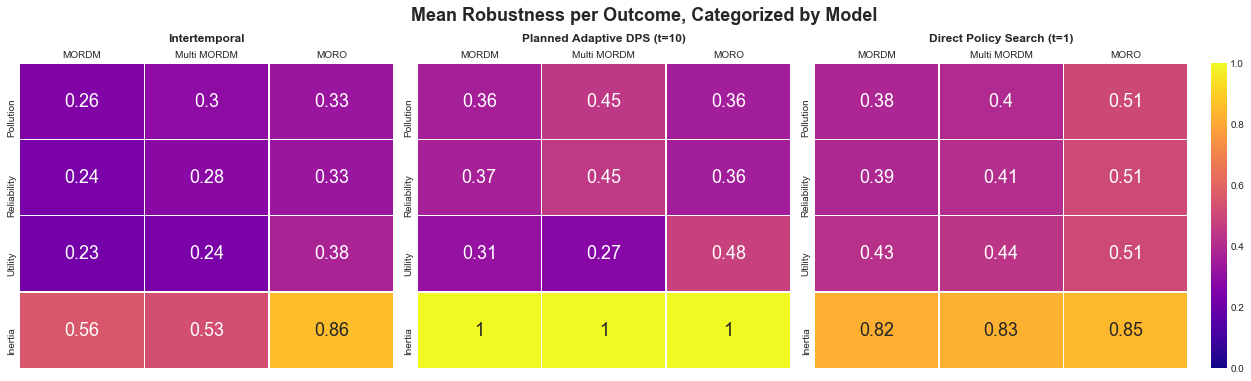

In [25]:
hmaps = buildHeatmapResults(robustData, rows='outcome', columns='method', categories='model')
buildAndSaveHeatmap(hmaps, categories='model')

# Pareto Size Heatmaps

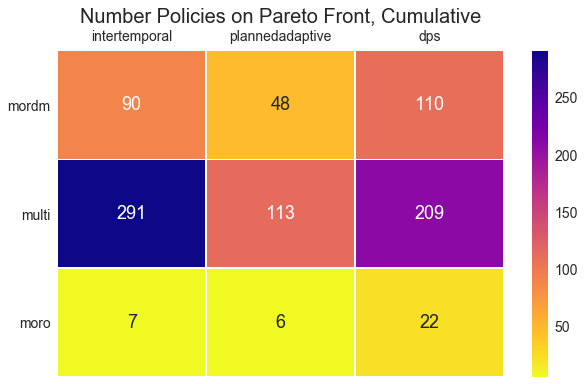

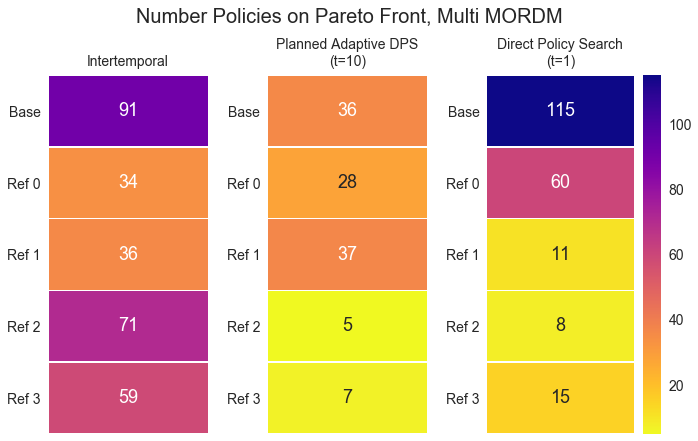

In [33]:
paretodicts = []
multi_paretodicts = []

for method, dat in data.items(): 
    for model in order('model'):
        paretoSize = 0
        for idx, nond in enumerate(dat['nondominated'][model]):
            ref = 'Ref ' + str(idx)
            if idx == len(dat['nondominated'][model]) - 1: 
                ref = 'Base'
            if method == 'multi': 
                multi_paretodicts.append({'model':model,'ref':ref,'pareto':nond.shape[0]})
                
            paretoSize += nond.shape[0]            
        paretodicts.append({'model':model,'method':method,'pareto':paretoSize})

pivot = pd.DataFrame(paretodicts).pivot(index='method', columns='model', values='pareto')
pivot = pivot.reindex_axis(order('model'), axis=1)
pivot = pivot.reindex_axis(order('method'), axis=0)
pivot.columns = order('model')
pivot.index = order('method')

fig = plt.figure(figsize=(10,6))
g = plt.subplot()

sns.set(font_scale=1.4)
sns.heatmap(pivot, ax=g, annot=True, cmap='plasma_r', linewidths=.5,
                cbar=True, yticklabels=True, fmt='g', annot_kws={'size':18})
g.axes.xaxis.tick_top()

g.axes.set_ylabel('')    
g.axes.set_xlabel('')
g.set_title('Number Policies on Pareto Front, Cumulative',y=1.07,fontsize=20)

plt.yticks(rotation=0) 
plt.show()

multipareto = pd.DataFrame(multi_paretodicts)
vmax = multipareto['pareto'].max()
vmin = multipareto['pareto'].min()

plotList = order('model')
pivot = {}
for idx, plotName in enumerate(plotList): 
    df = multipareto.loc[multipareto['model']==plotName]
    piv = df.pivot(index='ref', columns='model', values='pareto')
    piv.columns = [titles('model')[idx]]
    pivot[plotName] = piv

fig, axes = plt.subplots(ncols=3, figsize=(10, 6), sharex=False, gridspec_kw = {'width_ratios':[1,1,1.15]})
for idx, plotName in enumerate(plotList): 
    sns.heatmap(pivot[plotName], annot=True, cmap='plasma_r', linewidths=.5, ax=axes[idx], fmt='g',
                vmax=vmax, vmin=vmin, cbar=idx==len(plotList)-1, yticklabels=True, annot_kws={'size':18})
    axes[idx].xaxis.tick_top()
    
    axes[idx].set_ylabel('')    
    axes[idx].set_xlabel('')

plt.suptitle('Number Policies on Pareto Front, Multi MORDM', fontsize=20,y=1.03)

for ax in axes:
    mpl.pyplot.sca(ax)
    plt.yticks(rotation=0)
    
plt.tight_layout()
plt.show()

# Multi-Dimensional Robustness

In [4]:
def stats(g):
    ci95_hi = g.mean() + g.sem() * 1.96
    ci95_lo = g.mean() - g.sem() * 1.96
    mean = g.mean()
    
    return g.mean(), g.median(), ci95_lo, ci95_hi, g.min(), g.max(), g.quantile(0.10), g.quantile(0.90)

def make_pivot_table(data, rows=None, columns=None, values=None):
    stacked = pd.pivot_table(data, values=values, index=rows,
                             columns=columns, dropna=False)
    stacked.index.names = rows
    stacked.columns.names = columns

    return stacked

def buildStackedHeatmapResults(robustSummary, columns='method', rows='outcome', rowGroups='model', mapped='mean'): 
    outerRowOrder = order(rowGroups)
    innerRowOrder = order(columns)
    outerColumnOrder = order(rows)
    innerColumnOrder = ['mean', 'median','ci_low','ci_high','min','max','quartile_low','quartile_high']
    
    col = pd.MultiIndex(levels=[outerColumnOrder, 
                            innerColumnOrder],
                        labels=[np.repeat(list(range(len(outerColumnOrder))),len(innerColumnOrder)), 
                                np.tile(list(range(len(innerColumnOrder))),len(outerColumnOrder))],
                        names=[rows,'stat'])
    idx = pd.MultiIndex(levels=[outerRowOrder, innerRowOrder],
                        labels=[np.repeat(list(range(len(outerRowOrder))),len(innerRowOrder)), 
                                np.tile(list(range(len(innerRowOrder))),len(outerRowOrder))],
                        names=[rowGroups, columns])
    results = pd.DataFrame(np.zeros((idx.shape[0], col.shape[0])), columns=col, index=idx)

    group = robustSummary.groupby([rowGroups, columns])
    ci = group.apply(stats)

    for outcome in order(rows): 
        for outer in outerRowOrder: 
            for inner in innerRowOrder:
                for idx, stat in enumerate(innerColumnOrder): 
                    results.loc[(outer,inner),(outcome,stat)] = ci[outer][inner][idx][outcome]
    
    statDf = results.xs(mapped, level=1, axis=1)
    statDf = pd.DataFrame(statDf.to_records())

    dfs = []
    for outcome in order(rows): 
        df = statDf[[rowGroups,columns,outcome]]
        df.columns = [rowGroups,columns,'value']
        df[rows] = outcome
        dfs.append(df)
    df = pd.concat(dfs) 
    
    pivot = make_pivot_table(df, rows=[rowGroups, rows], columns=[columns], values='value')

    indexOrder = []
    for level1 in order(rowGroups):
        for level2 in order(rows):
            indexOrder.append((level1,level2))
    pivot = pivot.reindex(indexOrder)

    # Rename Rows
    outerRowOrder = pivot.index.levels[0]
    rowOrder = pivot.index.levels[1]
    pivot.index = pivot.index.set_levels([titles(rowGroups, outerRowOrder), titles(rows, rowOrder)], level=[0,1])
    # Rename columns
    pivot = pivot.reindex_axis(order(columns), axis=1)
    pivot.columns = titles(columns)
    
    # Rename stats table to match updated pivot table
    results.index = results.index.set_levels([titles('model'), titles('method')])
    results.columns = results.columns.set_levels([titles('outcome'),list(results.columns.levels[1])])
    
    return pivot, results.round(3)

In [31]:
def buildCumulativeHeatmap(pivot, labels=True, mapped='mean'): 
    if isinstance(labels, str): 
        plt.rc('text', usetex=True)
    
    fig = plt.figure(figsize=(7.5,9))
    gs = mpl.gridspec.GridSpec(1, 2, width_ratios=[1,3.2],wspace=0.01) 
    ax0 = plt.subplot(gs[0])

    ax_plot = fig.add_subplot(gs[1])

    hmap = sns.heatmap(pivot.values, ax=ax_plot, cmap='plasma', annot=False, fmt='', 
                       annot_kws={'size':9}, vmin=0, vmax=1)
    hmap.axes.xaxis.tick_top()
    hmap.axes.set_ylabel('')

    # Configure Axis Tick Labels
    hmap.axes.set_xticklabels(titles('method'), fontsize=10)
    ax_plot.set_yticks([])
    
#     put labels manually
    for y in range(labels.shape[0]):
        for x in range(labels.shape[1]):
            color = 'black' if pivot.iloc[y, x] > 0.8 else 'white'
            plt.text(x+0.5, y+0.3,labels[y, x][0], ha='center',va='center',color=color, 
                     family='sans-serif', size=10, weight='bold')
            plt.text(x+0.5, y+0.6,labels[y, x][1], ha='center',va='center',color=color, 
                     family='sans-serif', size=10)
#             plt.text(x+0.5, y+0.5,labels[y, x][0], ha='center',va='center',color=color, 
#                      family='sans-serif', size=16, weight='bold')


    # Configure line breaks
    linewidth = 10
    color = 'w'
    for i in range(1,12): 
        hmap.axhline(y=i, linewidth=1, color=color)
    hmap.axhline(y=4, linewidth=linewidth, color=color)
    hmap.axhline(y=8, linewidth=linewidth, color=color)
    hmap.axvline(x=1, linewidth=linewidth, color=color)
    hmap.axvline(x=2, linewidth=linewidth, color=color)
    
    #-- Dimension Titles --

    #Display Formatting
    ax_dim = fig.add_subplot(gs[0])
    ax_dim.set_ylim(ax_plot.get_ylim())
    ax_dim.set_xlim(0, 1)
    ax_dim.set_yticks([])
    ax_dim.set_xticks([])

    ax_dim.spines['left'].set_color('white')
    ax_dim.spines['left'].set_linewidth(1.0)
    ax_dim.spines['right'].set_color('white')
    ax_dim.spines['right'].set_linewidth(1.0)
    ax_dim.spines['top'].set_color('black')
    ax_dim.spines['top'].set_linewidth(1.0)
    ax_dim.spines['bottom'].set_color('black')
    ax_dim.spines['bottom'].set_linewidth(1.0)

    #Configure Name Text
    index = pivot.index[::-1]
    nr_levels = len(index.levels)
    levels = index.levels
    indices = index.values[::-1]

    #Add horizontal lines to grid
    ct = 1
    for i in range(len(index.levels[0])):
        place = [ct,ct+1,ct+2,ct+3]
        ax_dim.plot([0.5, 1], [place[0],place[0]], lw=1, color='gray')
        ax_dim.plot([0.5, 1], [place[1],place[1]], lw=1, color='gray')
        ax_dim.plot([0.5, 1], [place[2],place[2]], lw=1, color='gray')

        ax_dim.plot([0, 1], [place[3],place[3]], lw=1, color='black')
        ct += 4

    #Add both levels of text to grid
    currDim = ''
    offset = 1
    for idx, ind in enumerate(index.values[::-1]):         
        if ind[0] != currDim: 
            currDim = ind[0]
            ax_dim.text(1/(2*nr_levels) + 0/(nr_levels), len(index.levels[1])/2+idx, ind[0], ha='center', va='center',weight='bold', fontsize=10, rotation='vertical')

        ax_dim.text(1/(2*nr_levels) + 1/(nr_levels), 0.041667*len(index)+idx, ind[1], ha='center', va='center', fontsize=10)
    
    plt.suptitle(mapped.capitalize() + ' Robustness per Outcome',y=0.94,weight='bold',fontsize=14)

    plt.tight_layout()
    
    save_fig(fig, 'images/hmaps/', 'robustnes_heatmap_' + mapped)
    
    plt.show()
    
    return hmap

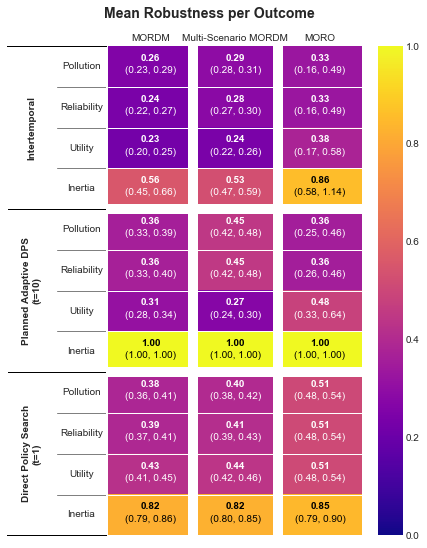

In [32]:
pivot, statFrame = buildStackedHeatmapResults(robustData)
labels = []
for dim, row in pivot.index: 
    labelset = []
    for col in pivot.columns:
        l = statFrame.loc[(dim, col),(row,'ci_low')]
        h = statFrame.loc[(dim, col),(row,'ci_high')]
        m = statFrame.loc[(dim, col),(row,'mean')]
        
#         label = r'$\bf{' + '{0:.2f}'.format(m) + "}$" + '\n(' + '{0:.2f}'.format(l) + ', ' + '{0:.2f}'.format(h) + ')'
        label = ('{0:.2f}'.format(m),'(' + '{0:.2f}'.format(l) + ', ' + '{0:.2f}'.format(h) + ')')
        labelset.append(label)
    labels.append(labelset)

fig = buildCumulativeHeatmap(pivot, labels=np.array(labels))

In [ ]:
pivot, statFrame = buildStackedHeatmapResults(critp, mapped='quartile_low')
labels = []
for dim, row in pivot.index: 
    labelset = []
    for col in pivot.columns:
#         l = statFrame.loc[(dim, col),(row,'quartile_low')]
#         h = statFrame.loc[(dim, col),(row,'quartile_high')]
        m = statFrame.loc[(dim, col),(row,'quartile_low')]
        label = ('{0:.2f}'.format(m),'')
        labelset.append(label)
    labels.append(labelset)

fig = buildCumulativeHeatmap(pivot, labels=np.array(labels), mapped='quartile_low')

In [ ]:
pivot, statFrame = buildStackedHeatmapResults(critp, mapped='quartile_high')
labels = []
for dim, row in pivot.index: 
    labelset = []
    for col in pivot.columns:
#         l = statFrame.loc[(dim, col),(row,'quartile_low')]
#         h = statFrame.loc[(dim, col),(row,'quartile_high')]
        m = statFrame.loc[(dim, col),(row,'quartile_high')]
        label = ('{0:.2f}'.format(m),'')
        labelset.append(label)
    labels.append(labelset)

fig = buildCumulativeHeatmap(pivot, labels=np.array(labels), mapped='quartile_high')

In [ ]:
pivot, statFrame = buildStackedHeatmapResults(critp)
labels = []
for dim, row in pivot.index: 
    labelset = []
    for col in pivot.columns:
        l = statFrame.loc[(dim, col),(row,'ci_low')]
        h = statFrame.loc[(dim, col),(row,'ci_high')]
        m = statFrame.loc[(dim, col),(row,'mean')]
        
#         label = r'$\bf{' + '{0:.2f}'.format(m) + "}$" + '\n(' + '{0:.2f}'.format(l) + ', ' + '{0:.2f}'.format(h) + ')'
        label = ('{0:.2f}'.format(m),'(' + '{0:.2f}'.format(l) + ', ' + '{0:.2f}'.format(h) + ')')
        labelset.append(label)
    labels.append(labelset)

fig = buildCumulativeHeatmap(pivot, labels=np.array(labels))

In [10]:
robustSummary = robustData

columns='method'
rows='outcome'
rowGroups='model'

outerRowOrder = order(rowGroups)
innerRowOrder = order(columns)
outerColumnOrder = order(rows)
innerColumnOrder = ['mean']

# build label repeats for the mutlilevel row index
policyOrder = list(range(len(robustSummary.policy.unique())))
policyRepeat = []
innerRowRepeat = []
outerRowRepeat = []
for i, outer in enumerate(outerRowOrder): 
    innerRowRepeat_1 = []
    for j, inner in enumerate(innerRowOrder): 
        policySet = robustSummary.loc[(robustSummary[rowGroups]==outer) & (robustSummary[columns]==inner)]['policy'].unique()
        policyRepeat.append(policySet)
        innerRowRepeat_1.append(np.repeat(j, len(policySet)))
    oneset = [item for sublist in innerRowRepeat_1 for item in sublist]
    innerRowRepeat.append(oneset)
    outerRowRepeat.append(np.repeat(i, len(oneset)))

col = pd.MultiIndex(levels=[outerColumnOrder, 
                            innerColumnOrder],
                 labels=[np.repeat(list(range(len(outerColumnOrder))),len(innerColumnOrder)), 
                         np.tile(list(range(len(innerColumnOrder))),len(outerColumnOrder))],
                 names=[rows, 'stat'])
idx = pd.MultiIndex(levels=[outerRowOrder, 
                            innerRowOrder, 
                            policyOrder],
                 labels=[[item for sublist in outerRowRepeat for item in sublist], 
                         [item for sublist in innerRowRepeat for item in sublist], 
                         [item for sublist in policyRepeat for item in sublist]],
                 names=[rowGroups, columns, 'policy'])
results = pd.DataFrame(np.zeros((idx.shape[0], col.shape[0])), columns=col, index=idx)

for colName in outerColumnOrder: 
    for outer in outerRowOrder: 
        for inner in innerRowOrder:
            for policy in robustSummary.loc[(robustSummary[rowGroups]==outer) & (robustSummary[columns]==inner)]['policy'].unique():
                val = robustSummary.loc[(robustSummary[rowGroups]==outer) & (robustSummary[columns]==inner) & (robustSummary['policy']==policy),colName]
                results.loc[(outer,inner,policy),(colName,'mean')] = list(val)[0]

In [11]:
#build dataframe with column values that indicate each key data point (row and column labels, value to heatmap)
mean = results.xs('mean',level=1,axis=1)
mean = pd.DataFrame(mean.to_records())
means = []
for name, grp in mean.groupby(['model','method']): 
    df = grp.sort_values(['max_P_percent'], ascending=[1])
    df = df.reset_index(drop=True)
    df['policy'] = df.index
    means.append(df)
mean = pd.concat(means)

In [13]:

pivots = {}
for outer in outerRowOrder: 
    dfs = []
    for outcome in order(rows): 
        df = mean.loc[mean[rowGroups]==outer][[rowGroups,columns,'policy',outcome]]
        df.columns = [rowGroups,columns,'policy','value']
        df[rows] = outcome
        dfs.append(df)
    df = pd.concat(dfs)
    pivot = pd.pivot_table(df, values='value', index=[rows],
                             columns=[columns, 'policy'], dropna=True)
    pivot = pivot.reindex(order(rows), axis=0)
    pivot.index = titles(rows)

    # Rename columns
    indexOrder = []
    for level1 in order(columns):
        policies = pivot[level1].columns
        for level2 in policies:  
            indexOrder.append((level1,level2))
    pivot = pivot.reindex(indexOrder, axis=1)
    columnLevel = pivot.columns.levels[0]
    pivot.columns = pivot.columns.set_levels([titles(columns, columnLevel)], level=[0])
    pivots[outer] = pivot

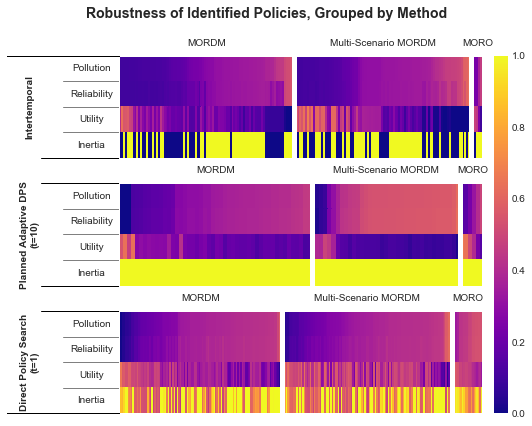

In [27]:
fig = plt.figure(figsize=(7.5, 5.7))

gs = mpl.gridspec.GridSpec(6, 4, width_ratios=[8,26,0.7,1],
                                height_ratios=[2,8,2,8,2,8], 
                           hspace=0, wspace=0)

idx = 1
hmaps = []
for name, pivot in pivots.items(): 
    ax = plt.subplot(gs[idx, 1:-2])
    hmap = sns.heatmap(pivot, annot=False, cmap='plasma', ax=ax,
                square=False, cbar=False, yticklabels=True, annot_kws={'size':9})
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
        
    col_ax = plt.subplot(gs[idx-1,1])
    col_ax.set_xlim(ax.get_xlim())
    col_ax.set_ylim(0, 1)
    col_ax.set_yticks([])
    col_ax.set_xticks([])

    col_ax.spines['top'].set_color('white')
    col_ax.spines['top'].set_linewidth(1.0)
    col_ax.spines['bottom'].set_color('white')
    col_ax.spines['bottom'].set_linewidth(1.0)
    col_ax.spines['left'].set_color('white')
    col_ax.spines['left'].set_linewidth(1.0)
    col_ax.spines['right'].set_color('white')
    col_ax.spines['right'].set_linewidth(1.0)
    
    padding = 0.5
#     col_ax.plot([0.1,0.1], [0,1], lw=1, color='black')
#     col_ax.plot([col_ax.get_xlim()[1]-padding, col_ax.get_xlim()[1]-padding], [0,1], lw=1, color='black')
    
    drawLine = 0
    linewidth = 5
    color = 'w'
    for method in titles('method'): 
        prevDrawLine = drawLine
        drawLine += pivot[method].shape[1]
        hmap.axvline(x=drawLine, linewidth=linewidth, color=color)
    
#         col_ax.plot([drawLine, drawLine], [0,1], lw=1, color='black')
        col_ax.text((drawLine-prevDrawLine)/2+prevDrawLine, 0.5, method, ha='center', va='center', fontsize=10)
    idx += 2

# Add Colorbar
cbarax = plt.subplot(gs[1:, -1])
plt.subplot(gs[1:, -1])
cmap = mpl.cm.plasma
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cbar = mpl.colorbar.ColorbarBase(cbarax, cmap=cmap, norm=norm)
cbar.outline.set_visible(False)

# Add Row Labels
ax_dim = plt.subplot(gs[1:,0])
ax_dim.set_ylim(0,14)
ax_dim.set_xlim(0, 1)
ax_dim.set_yticks([])
ax_dim.set_xticks([])

ax_dim.spines['left'].set_color('white')
ax_dim.spines['left'].set_linewidth(1.0)
ax_dim.spines['right'].set_color('white')
ax_dim.spines['right'].set_linewidth(1.0)
ax_dim.spines['top'].set_color('black')
ax_dim.spines['top'].set_linewidth(1.0)
ax_dim.spines['bottom'].set_color('black')
ax_dim.spines['bottom'].set_linewidth(1.0)

#Add horizontal lines to row labels
ct = 1
for i in range(len(order('model'))):
    place = [ct,ct+1,ct+2,ct+3,ct+4]
    ax_dim.plot([0.5, 1], [place[0],place[0]], lw=1, color='grey')
    ax_dim.plot([0.5, 1], [place[1],place[1]], lw=1, color='grey')
    ax_dim.plot([0.5, 1], [place[2],place[2]], lw=1, color='grey')

    ax_dim.plot([0.3, 1], [place[3],place[3]], lw=1, color='black')
    ax_dim.plot([0.3, 1], [place[4],place[4]], lw=1, color='black')
    ct += 5
    

#Add both levels of text to grid
currDim = ''
offset = 1
top = ax_dim.get_ylim()[1]
numInnerLevels = 4
modelTitles = titles('model')
for idx, model in enumerate(modelTitles): 
    ax_dim.text(0.2, top-numInnerLevels/2, model, ha='center', va='center',weight='bold', fontsize=10,rotation='vertical')
    for robustIdx, robust in enumerate(pivot.index): 
        ax_dim.text(0.75, top-0.5-1*robustIdx, robust, ha='center', va='center', fontsize=10)
            
    top -= numInnerLevels + 1


# Finalize
plt.suptitle('Robustness of Identified Policies, Grouped by Method', fontsize=14,weight='bold',y=1.03)
plt.tight_layout()

save_fig(plt,'images/hmaps/','individualrobustness')

plt.show()